# Итоговое Аттестационное задание
## Задача:
Вы добрались до финального задания.
Спасибо, что прошли этот путь вместе со мной 🙏
Необходимо выбрать один из представленных наборов данных ниже:
1. Статистика о сне и здоровье https://www.kaggle.com/propertiessets/hanaksoy/health-and-sleep-statistics
2. Топ-12550 игр в стим маркетплейсе https://www.kaggle.com/propertiessets/alicemtopcu/top-12550-games-on-steam-by-revenue-09-09-2024
3. Yandex Музыка https://www.kaggle.com/propertiessets/antonbelyaevd/yandex-music-top-100-songs
4. Что ищут в Wildberries https://www.kaggle.com/propertiessets/demartlectus/wildberries-search-queries-from-wildhack-2021
5. Умный дом https://www.kaggle.com/propertiessets/taranvee/smart-home-propertiesset-with-weather-information
6. ФастФуд https://www.kaggle.com/propertiessets/ulrikthygepedersen/fastfood-nutrition
7. Книги https://www.kaggle.com/propertiessets/saurabhbagchi/books-propertiesset
8. CO2 значения https://www.kaggle.com/propertiessets/mathchi/co2-intensity-of-electricity-generation
9. ИЛИ взять данные из аналитического сервиса https://properties.ozon.ru/

**ВНИМАНИЕ!**
Вы можете привлечь ваш собственный датасет для финальной аттестации.

### Задание
1. Любым удобным вам техническим способом (DBeaver, Python или используя AI) загрузите набор данных в вашу схему базы данных
2. Нормализуйте выбранную модель данных, выделив из оригинальных данных таблицы справочники и таблицу оперативных данных. Укажите необходимые Внешние / Уникальные ключи и необходимые индексы.

    Здесь, возможно вам понадобится определенный тип таблицы и определенные типы индексов в рамках семейства `BTree`. (Возможно объем данных не такой большой - но постарайтесь заложить эту функциональность)
3. Создайте табличные триггеры только на одной из справочных таблиц для CRUD операций по аудиту любых изменений для сохранения истории изменений
4. Напишите одну pl/pgsql функцию, которая возвращает аудит изменений по указанной в параметре справочной таблице в виде табличных данных, например
    ```sql
    SELECT * FROM fnc_audit(‘справочник1’)
    ```

    | Дата изменения      | Примененная операция | Измененные данные |
    |---------------------|----------------------|-------------------|
    | 2024-10-19 21:00:34 | INSERT               | ...               |
    | ...                 | ...                  | ...               |

5. Подготовьте 3 интересных по вашему мнению инсайта из данных в виде SQL выражений, выраженных в `VIEW` или `MATERIALIZED VIEW` в вашей схеме данных и визуализированных в инструменте SuperSet

## Описание
В рамках задания был произведен анализ данных по взаимодействию пользователей с работой очередей в RabbitMQ.

Необходимо выявить:
1. Самые популярные фильтры которые используют пользователи.
2. Пользователей с максимальным количеством очередей.
3. Параметры наиболее часто встречающиеся у пользователей.

In [ ]:
%%sql
-- Создание схемы
CREATE SCHEMA IF NOT EXISTS ivan_patakin;

-- Сначала создадим ненормализованную таблицу
CREATE TABLE ivan_patakin.raw_data (
    id SERIAL PRIMARY KEY,
    name VARCHAR(255) NOT NULL,
    durable BOOLEAN NOT NULL,
    auto_delete BOOLEAN NOT NULL,
    arguments JSONB NOT NULL,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

-- Создадим индекс для ускорения поиска по name и jsonb
CREATE INDEX idx_raw_data_name ON ivan_patakin.raw_data(name);
CREATE INDEX idx_raw_data_arguments ON ivan_patakin.raw_data USING GIN(arguments);

In [29]:
import json
import psycopg2

connection = psycopg2.connect(
    dbname="",
    user="",
    password="",
    host="localhost",
    port="5432"
)
cursor = connection.cursor()

# Загрузка данных из JSON-файла
with open('Data/data.json', 'r') as file:
    data = json.load(file)

# Вставка данных в ненормализованную таблицу
try:
    for item in data:
        cursor.execute(
            """
            INSERT INTO ivan_patakin.raw_data
            (name, durable, auto_delete, arguments)
            VALUES (%s, %s, %s, %s)
            """,
            (item['name'], item['durable'], item['auto_delete'], json.dumps(item['arguments']))
        )

    connection.commit()
    print(f"Загружено {len(data)} записей в ненормализованную таблицу")
except Exception as e:
    connection.rollback()
    print(f"Ошибка при загрузке данных: {e}")
finally:
    cursor.close()
    connection.close()

Загружено 3207 записей в ненормализованную таблицу


In [ ]:
%%sql
-- Создание таблицы пользователей
CREATE TABLE ivan_patakin.users (
    user_id UUID PRIMARY KEY,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    user_login VARCHAR(20)
);

-- Создание таблицы фильтров
CREATE TABLE ivan_patakin.filters (
    filter_id INTEGER PRIMARY KEY,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

-- Создание справочника аргументов
CREATE TABLE ivan_patakin.arguments (
    argument_id SERIAL PRIMARY KEY,
    argument_name VARCHAR(50) NOT NULL UNIQUE,
    description TEXT,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

-- Операционная таблица связи пользователей и фильтров
CREATE TABLE ivan_patakin.user_filters (
    user_filter_id SERIAL PRIMARY KEY,
    user_id UUID NOT NULL REFERENCES ivan_patakin.users(user_id),
    filter_id INTEGER NOT NULL REFERENCES ivan_patakin.filters(filter_id),
    durable BOOLEAN NOT NULL,
    auto_delete BOOLEAN NOT NULL,
    expires_ms INTEGER,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    UNIQUE (user_id, filter_id)
);

-- Создание таблицы для хранения значений аргументов для фильтров
CREATE TABLE ivan_patakin.filter_argument_values (
    value_id SERIAL PRIMARY KEY,
    user_filter_id INTEGER NOT NULL REFERENCES ivan_patakin.user_filters(user_filter_id),
    argument_id INTEGER NOT NULL REFERENCES ivan_patakin.arguments(argument_id),
    argument_value INTEGER,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    UNIQUE (user_filter_id, argument_id)
);

-- Создание индексов для оптимизации запросов
CREATE INDEX idx_filter_argument_values_user_filter_id ON ivan_patakin.filter_argument_values (user_filter_id);
CREATE INDEX idx_filter_argument_values_argument_id ON ivan_patakin.filter_argument_values (argument_id);
CREATE INDEX idx_user_filters_user_id ON ivan_patakin.user_filters (user_id);
CREATE INDEX idx_user_filters_filter_id ON ivan_patakin.user_filters (filter_id);

-- Таблица аудита для фильтров
CREATE TABLE ivan_patakin.filters_audit (
    audit_id SERIAL PRIMARY KEY,
    operation VARCHAR(10) NOT NULL,
    timestamp TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    filter_id INTEGER NOT NULL,
    old_data JSONB,
    new_data JSONB
);

-- Таблица аудита для пользователей
CREATE TABLE ivan_patakin.users_audit (
    audit_id SERIAL PRIMARY KEY,
    operation VARCHAR(10) NOT NULL,
    timestamp TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    user_id UUID NOT NULL,
    old_data JSONB,
    new_data JSONB
);

-- Таблица аудита для значений аргументов
CREATE TABLE ivan_patakin.filter_argument_values_audit (
    audit_id SERIAL PRIMARY KEY,
    operation VARCHAR(10) NOT NULL,
    timestamp TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    value_id INTEGER NOT NULL,
    old_data JSONB,
    new_data JSONB
);

In [ ]:
%%sql
-- Функция для триггера аудита фильтров
CREATE OR REPLACE FUNCTION ivan_patakin.filter_audit_trigger()
RETURNS TRIGGER AS $$
BEGIN
    IF TG_OP = 'INSERT' THEN
        INSERT INTO ivan_patakin.filters_audit(operation, filter_id, new_data)
        VALUES ('INSERT', NEW.filter_id, to_jsonb(NEW));
        RETURN NEW;
    ELSIF TG_OP = 'UPDATE' THEN
        INSERT INTO ivan_patakin.filters_audit(operation, filter_id, old_data, new_data)
        VALUES ('UPDATE', OLD.filter_id, to_jsonb(OLD), to_jsonb(NEW));
        RETURN NEW;
    ELSIF TG_OP = 'DELETE' THEN
        INSERT INTO ivan_patakin.filters_audit(operation, filter_id, old_data)
        VALUES ('DELETE', OLD.filter_id, to_jsonb(OLD));
        RETURN OLD;
    END IF;
    RETURN NULL;
END;
$$ LANGUAGE plpgsql;

-- Создание триггеров для фильтров
CREATE TRIGGER filter_audit_insert_update
AFTER INSERT OR UPDATE ON ivan_patakin.filters
FOR EACH ROW EXECUTE FUNCTION ivan_patakin.filter_audit_trigger();

CREATE TRIGGER filter_audit_delete
BEFORE DELETE ON ivan_patakin.filters
FOR EACH ROW EXECUTE FUNCTION ivan_patakin.filter_audit_trigger();

-- Функция для триггера аудита пользователей
CREATE OR REPLACE FUNCTION ivan_patakin.user_audit_trigger()
RETURNS TRIGGER AS $$
BEGIN
    IF TG_OP = 'INSERT' THEN
        INSERT INTO ivan_patakin.users_audit(operation, user_id, new_data)
        VALUES ('INSERT', NEW.user_id, to_jsonb(NEW));
        RETURN NEW;
    ELSIF TG_OP = 'UPDATE' THEN
        INSERT INTO ivan_patakin.users_audit(operation, user_id, old_data, new_data)
        VALUES ('UPDATE', OLD.user_id, to_jsonb(OLD), to_jsonb(NEW));
        RETURN NEW;
    ELSIF TG_OP = 'DELETE' THEN
        INSERT INTO ivan_patakin.users_audit(operation, user_id, old_data)
        VALUES ('DELETE', OLD.user_id, to_jsonb(OLD));
        RETURN OLD;
    END IF;
    RETURN NULL;
END;
$$ LANGUAGE plpgsql;

-- Создание триггеров для пользователей
CREATE TRIGGER user_audit_insert_update
AFTER INSERT OR UPDATE ON ivan_patakin.users
FOR EACH ROW EXECUTE FUNCTION ivan_patakin.user_audit_trigger();

CREATE TRIGGER user_audit_delete
BEFORE DELETE ON ivan_patakin.users
FOR EACH ROW EXECUTE FUNCTION ivan_patakin.user_audit_trigger();

-- Функция для триггера аудита значений аргументов
CREATE OR REPLACE FUNCTION ivan_patakin.filter_argument_value_audit_trigger()
RETURNS TRIGGER AS $$
BEGIN
    IF TG_OP = 'INSERT' THEN
        INSERT INTO ivan_patakin.filter_argument_values_audit(operation, value_id, new_data)
        VALUES ('INSERT', NEW.value_id, to_jsonb(NEW));
        RETURN NEW;
    ELSIF TG_OP = 'UPDATE' THEN
        INSERT INTO ivan_patakin.filter_argument_values_audit(operation, value_id, old_data, new_data)
        VALUES ('UPDATE', OLD.value_id, to_jsonb(OLD), to_jsonb(NEW));
        RETURN NEW;
    ELSIF TG_OP = 'DELETE' THEN
        INSERT INTO ivan_patakin.filter_argument_values_audit(operation, value_id, old_data)
        VALUES ('DELETE', OLD.value_id, to_jsonb(OLD));
        RETURN OLD;
    END IF;
    RETURN NULL;
END;
$$ LANGUAGE plpgsql;

-- Создание триггеров для аргументов
CREATE TRIGGER filter_argument_value_audit_insert_update
AFTER INSERT OR UPDATE ON ivan_patakin.filter_argument_values
FOR EACH ROW EXECUTE FUNCTION ivan_patakin.filter_argument_value_audit_trigger();

CREATE TRIGGER filter_argument_value_audit_delete
BEFORE DELETE ON ivan_patakin.filter_argument_values
FOR EACH ROW EXECUTE FUNCTION ivan_patakin.filter_argument_value_audit_trigger();

In [ ]:
%%sql
-- Функция аудита
CREATE OR REPLACE FUNCTION ivan_patakin.fnc_audit(table_name TEXT)
RETURNS TABLE (
    audit_date TIMESTAMP,
    operation_type TEXT,
    changed_data JSONB
) AS $$
BEGIN
    IF table_name = 'filters' THEN
        RETURN QUERY
        SELECT
            timestamp AS audit_date,
            CASE
                WHEN operation = 'INSERT' THEN 'INSERT'
                WHEN operation = 'UPDATE' THEN 'UPDATE'
                WHEN operation = 'DELETE' THEN 'DELETE'
                ELSE 'UNKNOWN'
            END AS operation_type,
            CASE
                WHEN operation = 'INSERT' THEN new_data
                WHEN operation = 'DELETE' THEN old_data
                WHEN operation = 'UPDATE' THEN jsonb_build_object(
                    'old', old_data,
                    'new', new_data
                )
            END AS changed_data
        FROM ivan_patakin.filters_audit
        ORDER BY timestamp DESC;
    ELSIF table_name = 'users' THEN
        RETURN QUERY
        SELECT
            timestamp AS audit_date,
            CASE
                WHEN operation = 'INSERT' THEN 'INSERT'
                WHEN operation = 'UPDATE' THEN 'UPDATE'
                WHEN operation = 'DELETE' THEN 'DELETE'
                ELSE 'UNKNOWN'
            END AS operation_type,
            CASE
                WHEN operation = 'INSERT' THEN new_data
                WHEN operation = 'DELETE' THEN old_data
                WHEN operation = 'UPDATE' THEN jsonb_build_object(
                    'old', old_data,
                    'new', new_data
                )
            END AS changed_data
        FROM ivan_patakin.users_audit
        ORDER BY timestamp DESC;
    ELSIF table_name = 'filter_argument_values' THEN
        RETURN QUERY
        SELECT
            timestamp AS audit_date,
            CASE
                WHEN operation = 'INSERT' THEN 'INSERT'
                WHEN operation = 'UPDATE' THEN 'UPDATE'
                WHEN operation = 'DELETE' THEN 'DELETE'
                ELSE 'UNKNOWN'
            END AS operation_type,
            CASE
                WHEN operation = 'INSERT' THEN new_data
                WHEN operation = 'DELETE' THEN old_data
                WHEN operation = 'UPDATE' THEN jsonb_build_object(
                    'old', old_data,
                    'new', new_data
                )
            END AS changed_data
        FROM ivan_patakin.filter_argument_values_audit
        ORDER BY timestamp DESC;
    ELSE
        RAISE EXCEPTION 'Неподдерживаемая таблица: %', table_name;
    END IF;
END;
$$ LANGUAGE plpgsql;

In [ ]:
%%sql
-- Заполнение нормализованных таблиц из ненормализованной
-- 1. Извлечение пользователей и фильтров
INSERT INTO ivan_patakin.users (user_id)
SELECT DISTINCT
    (regexp_match(name, 'user\.([0-9a-f\-]+)\.\d+'))[1]::uuid AS user_id
FROM ivan_patakin.raw_data
WHERE regexp_match(name, 'user\.([0-9a-f\-]+)\.\d+') IS NOT NULL;

INSERT INTO ivan_patakin.filters (filter_id)
SELECT DISTINCT
    (regexp_match(name, 'user\.[0-9a-f\-]+\.(\d+)'))[1]::integer AS filter_id
FROM ivan_patakin.raw_data
WHERE regexp_match(name, 'user\.[0-9a-f\-]+\.(\d+)') IS NOT NULL;

-- 2. Связь пользователей и фильтров
INSERT INTO ivan_patakin.user_filters (user_id, filter_id, durable, auto_delete, expires_ms)
SELECT
    (regexp_match(name, 'user\.([0-9a-f\-]+)\.\d+'))[1]::uuid AS user_id,
    (regexp_match(name, 'user\.[0-9a-f\-]+\.(\d+)'))[1]::integer AS filter_id,
    durable,
    auto_delete,
    (arguments->>'x-expires')::integer AS expires_ms
FROM ivan_patakin.raw_data
WHERE regexp_match(name, 'user\.([0-9a-f\-]+)\.\d+') IS NOT NULL
AND regexp_match(name, 'user\.[0-9a-f\-]+\.(\d+)') IS NOT NULL;

-- 3. Извлечение аргументов
INSERT INTO ivan_patakin.arguments (argument_name, description)
WITH keys AS (
    SELECT DISTINCT jsonb_object_keys(arguments) AS argument_name
    FROM ivan_patakin.raw_data
)
SELECT
    argument_name,
    'Аргумент ' || argument_name
FROM keys;

-- 4. Связь аргументов и их значений
WITH arg_values AS (
    SELECT
        uf.user_filter_id,
        a.argument_id,
        (rd.arguments->>a.argument_name)::integer AS argument_value
    FROM ivan_patakin.raw_data rd
    JOIN ivan_patakin.users u ON (regexp_match(rd.name, 'user\.([0-9a-f\-]+)\.\d+'))[1]::uuid = u.user_id
    JOIN ivan_patakin.filters f ON (regexp_match(rd.name, 'user\.[0-9a-f\-]+\.(\d+)'))[1]::integer = f.filter_id
    JOIN ivan_patakin.user_filters uf ON u.user_id = uf.user_id AND f.filter_id = uf.filter_id
    JOIN ivan_patakin.arguments a ON rd.arguments ? a.argument_name
)
INSERT INTO ivan_patakin.filter_argument_values (user_filter_id, argument_id, argument_value)
SELECT
    user_filter_id,
    argument_id,
    argument_value
FROM arg_values
WHERE argument_value IS NOT NULL;

In [30]:
%%sql
SELECT * FROM ivan_patakin.fnc_audit('users');

,audit_date,operation_type,changed_data
0,2025-07-14 12:05:49.740689,INSERT,"{""user_id"": ""05017cc1-e9c2-4385-874e-9dd7d1e1b..."
1,2025-07-14 12:05:49.740689,INSERT,"{""user_id"": ""dd32465e-2c63-40e8-ad34-7a4d6f1e1..."
2,2025-07-14 12:05:49.740689,INSERT,"{""user_id"": ""e48e539b-ab26-4cbb-a110-bc806e88e..."
3,2025-07-14 12:05:49.740689,INSERT,"{""user_id"": ""fa18a905-1cb8-4923-bed2-eff2677c9..."
4,2025-07-14 12:05:49.740689,INSERT,"{""user_id"": ""1aadf781-7cd9-4413-a3c2-fb52d3741..."
...,...,...,...
1364,2025-07-14 12:05:49.740689,INSERT,"{""user_id"": ""fa99d4b4-be13-4d7d-9f53-cca0402aa..."
1365,2025-07-14 12:05:49.740689,INSERT,"{""user_id"": ""e5f08507-893b-4e20-b14b-b0aa1c2d3..."
1366,2025-07-14 12:05:49.740689,INSERT,"{""user_id"": ""bd986ade-3959-40aa-96b3-ebb754997..."
1367,2025-07-14 12:05:49.740689,INSERT,"{""user_id"": ""ff10c2b4-d286-4ce9-8604-589b713ab..."


In [ ]:
%%sql
ALTER TABLE ivan_patakin.users ADD COLUMN username VARCHAR(50);

In [31]:
import psycopg2
from faker import Faker

fake = Faker()

connection = psycopg2.connect(
    dbname="",
    user="",
    password="",
    host="localhost",
    port="5432"
)
cursor = connection.cursor()

try:
    cursor.execute("SELECT user_id FROM ivan_patakin.users ORDER BY user_id")
    users = cursor.fetchall()

    for i, (user_id,) in enumerate(users):
        if i % 3 == 0:
            username = fake.user_name()[:20]
            cursor.execute(
                "UPDATE ivan_patakin.users SET username = %s WHERE user_id = %s",
                (username, user_id)
            )

    connection.commit()
    print(f"Всего обновлено {len(users) // 3 + (1 if len(users) % 3 > 0 else 0)} пользователей")

except Exception as e:
    connection.rollback()
    print(f"Ошибка при обновлении данных: {e}")

finally:
    cursor.close()
    connection.close()

Всего обновлено 457 пользователей


In [32]:
%%sql
SELECT * FROM ivan_patakin.fnc_audit('users');

,audit_date,operation_type,changed_data
0,2025-07-14 12:05:50.980453,UPDATE,"{""new"": {""user_id"": ""0010db1d-5850-47a7-9619-3..."
1,2025-07-14 12:05:50.980453,UPDATE,"{""new"": {""user_id"": ""0043f4b1-375d-4534-aa13-f..."
2,2025-07-14 12:05:50.980453,UPDATE,"{""new"": {""user_id"": ""00c56c4f-5983-4a18-ad36-2..."
3,2025-07-14 12:05:50.980453,UPDATE,"{""new"": {""user_id"": ""01355104-e60c-4052-a5d9-7..."
4,2025-07-14 12:05:50.980453,UPDATE,"{""new"": {""user_id"": ""01b47dd6-3c95-42e1-bef5-0..."
...,...,...,...
1821,2025-07-14 12:05:49.740689,INSERT,"{""user_id"": ""f00ca1c4-5d9c-404e-8e50-a8c8afcbd..."
1822,2025-07-14 12:05:49.740689,INSERT,"{""user_id"": ""0ab5ca0b-c3f2-4b9e-8aa5-7a918c8da..."
1823,2025-07-14 12:05:49.740689,INSERT,"{""user_id"": ""f5f13a3a-72e1-4570-be29-0eee0ce02..."
1824,2025-07-14 12:05:49.740689,INSERT,"{""user_id"": ""712d4dac-1baa-4d0b-9a5f-e1b4bd86e..."


In [ ]:
%%sql
-- Количество фильтров по пользователю
CREATE MATERIALIZED VIEW ivan_patakin.user_filter_count AS
SELECT
    u.user_id,
    COUNT(uf.filter_id) AS filter_count
FROM ivan_patakin.users u
LEFT JOIN ivan_patakin.user_filters uf ON u.user_id = uf.user_id
GROUP BY u.user_id
ORDER BY filter_count DESC;

-- Самые популярные фильтры
CREATE MATERIALIZED VIEW ivan_patakin.popular_filters AS
SELECT
    f.filter_id,
    COUNT(uf.user_id) AS user_count
FROM ivan_patakin.filters f
LEFT JOIN ivan_patakin.user_filters uf ON f.filter_id = uf.filter_id
GROUP BY f.filter_id
ORDER BY user_count DESC;

-- Анализ аргументов
CREATE MATERIALIZED VIEW ivan_patakin.argument_statistics AS
SELECT
    a.argument_name,
    COUNT(fav.value_id) AS usage_count,
    MIN(fav.argument_value) AS min_value,
    MAX(fav.argument_value) AS max_value,
    AVG(fav.argument_value) AS avg_value,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY fav.argument_value) AS median_value
FROM ivan_patakin.arguments a
LEFT JOIN ivan_patakin.filter_argument_values fav ON a.argument_id = fav.argument_id
GROUP BY a.argument_name, a.argument_id
ORDER BY usage_count DESC;

-- Самые высокие значения аргументов
CREATE MATERIALIZED VIEW ivan_patakin.extreme_argument_values AS
SELECT
    fav.value_id,
    uf.user_id,
    uf.filter_id,
    a.argument_name,
    fav.argument_value,
    RANK() OVER(PARTITION BY a.argument_id ORDER BY fav.argument_value DESC) as rank
FROM ivan_patakin.filter_argument_values fav
JOIN ivan_patakin.user_filters uf ON fav.user_filter_id = uf.user_filter_id
JOIN ivan_patakin.arguments a ON fav.argument_id = a.argument_id
WHERE fav.argument_value IS NOT NULL;

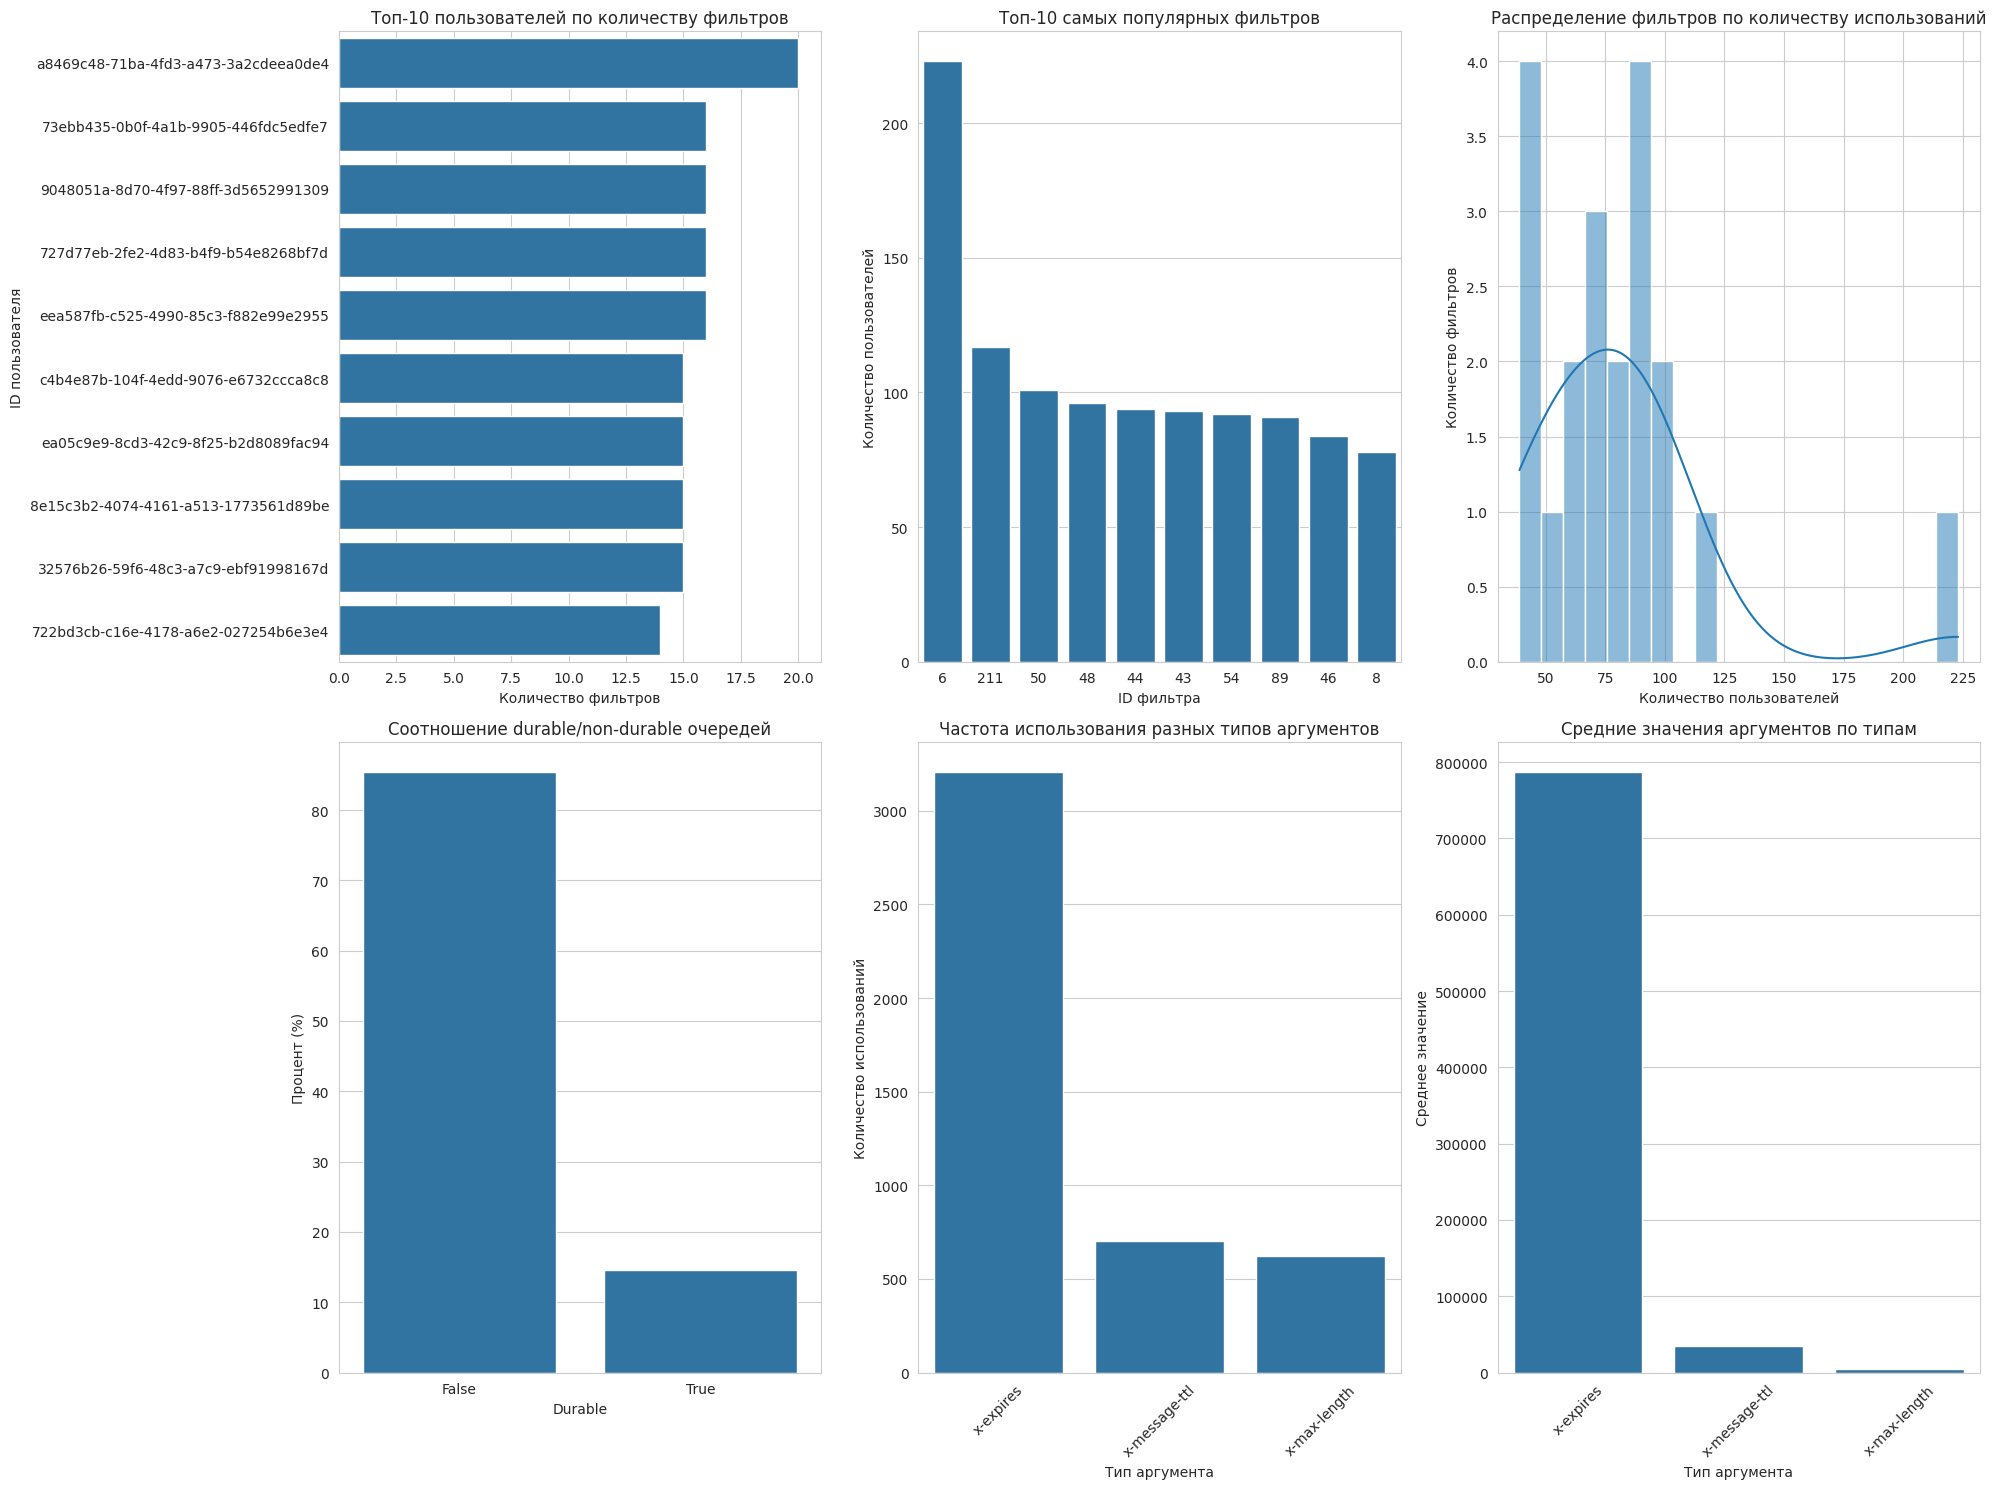

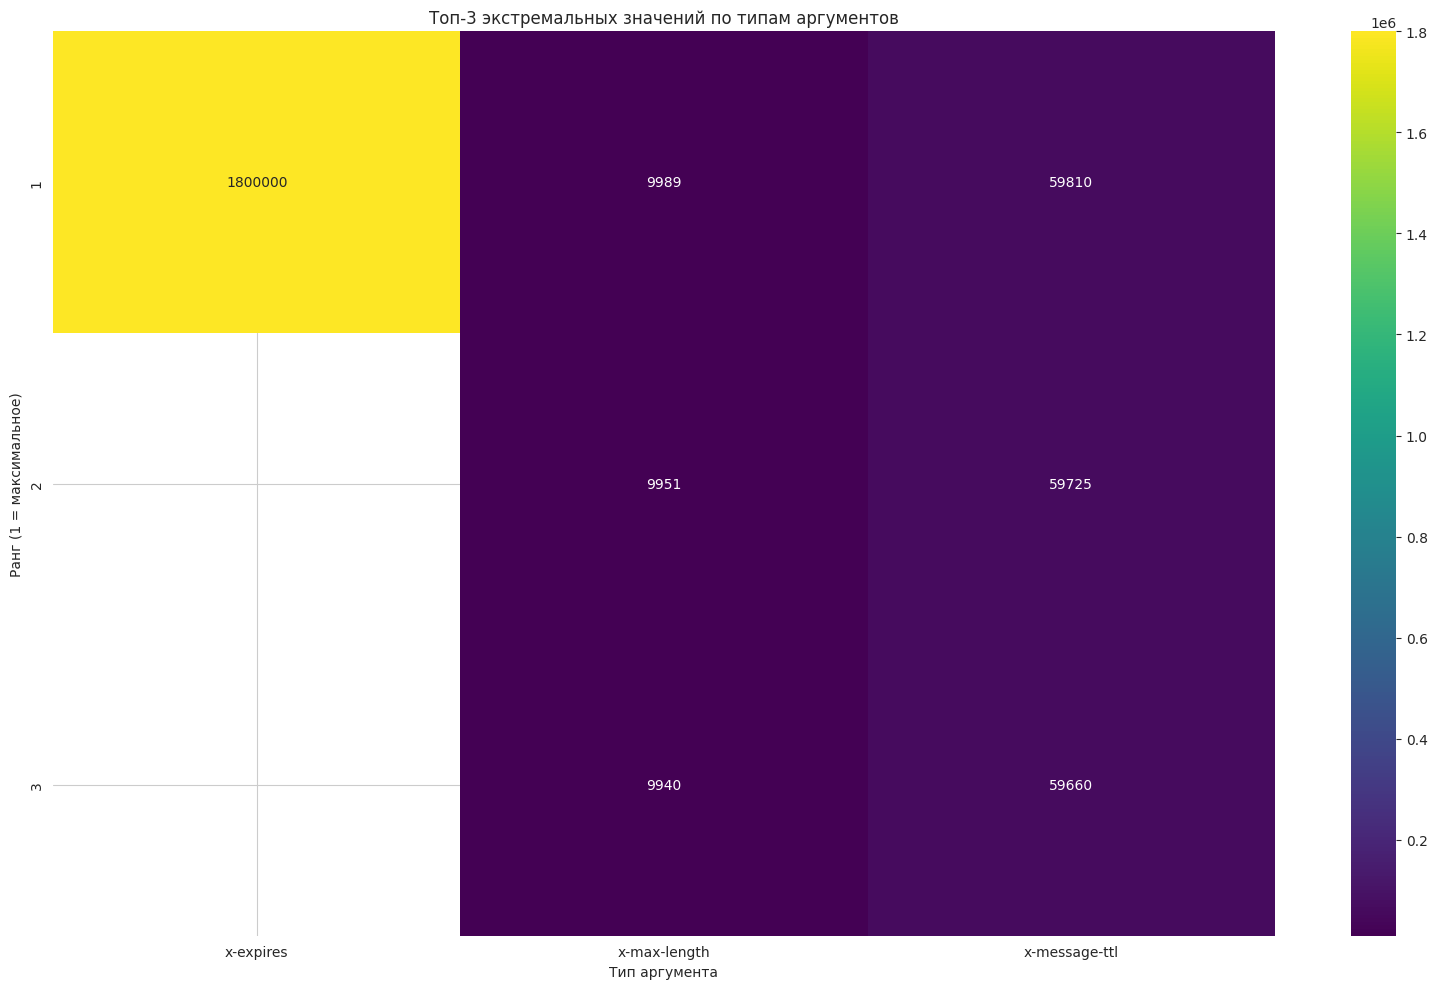

In [33]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

connection = psycopg2.connect(
    dbname="",
    user="",
    password="",
    host="localhost",
    port="5432"
)
cursor = connection.cursor()

cursor.execute("REFRESH MATERIALIZED VIEW ivan_patakin.user_filter_count;")
cursor.execute("REFRESH MATERIALIZED VIEW ivan_patakin.popular_filters;")
cursor.execute("REFRESH MATERIALIZED VIEW ivan_patakin.argument_statistics;")
cursor.execute("REFRESH MATERIALIZED VIEW ivan_patakin.extreme_argument_values;")
connection.commit()

# 1. Количество фильтров по пользователю
cursor.execute("SELECT * FROM ivan_patakin.user_filter_count LIMIT 20;")
user_filter_data = pd.DataFrame(cursor.fetchall(), columns=['user_id', 'filter_count'])

# 2. Самые популярные фильтры
cursor.execute("SELECT * FROM ivan_patakin.popular_filters LIMIT 20;")
popular_filters_data = pd.DataFrame(cursor.fetchall(), columns=['filter_id', 'user_count'])

# 3. Соотношение durable/non-durable очередей
cursor.execute("SELECT durable, COUNT(*) AS queue_count, ROUND(COUNT(*)::numeric / SUM(COUNT(*)) OVER() * 100, 2) AS percentage FROM ivan_patakin.user_filters GROUP BY durable;")
durability_data = pd.DataFrame(cursor.fetchall(), columns=['durable', 'queue_count', 'percentage'])

# 4. Статистика аргументов
cursor.execute("SELECT * FROM ivan_patakin.argument_statistics;")
arg_stats = pd.DataFrame(cursor.fetchall(),
                        columns=['argument_name', 'usage_count', 'min_value',
                                'max_value', 'avg_value', 'median_value'])

# 5. Экстремальные значения аргументов (топ-3 для каждого типа)
cursor.execute("SELECT * FROM ivan_patakin.extreme_argument_values WHERE rank <= 3;")
extreme_values = pd.DataFrame(cursor.fetchall(),
                             columns=['value_id', 'user_id', 'filter_id',
                                     'argument_name', 'argument_value', 'rank'])
cursor.close()
connection.close()

plt.figure(figsize=(20, 15))

# 1. Количество фильтров по пользователю (топ-10)
plt.subplot(2, 3, 1)
top_users = user_filter_data.nlargest(10, 'filter_count')
sns.barplot(x=top_users['filter_count'].values, y=top_users['user_id'].astype(str).values)
plt.title('Топ-10 пользователей по количеству фильтров')
plt.xlabel('Количество фильтров')
plt.ylabel('ID пользователя')

# 2. Самые популярные фильтры (топ-10)
plt.subplot(2, 3, 2)
top_filters = popular_filters_data.nlargest(10, 'user_count')
sns.barplot(x=top_filters['filter_id'].astype(str).values, y=top_filters['user_count'].values)
plt.title('Топ-10 самых популярных фильтров')
plt.xlabel('ID фильтра')
plt.ylabel('Количество пользователей')

# 3. Распределение фильтров по количеству пользователей
plt.subplot(2, 3, 3)
sns.histplot(popular_filters_data['user_count'], bins=20, kde=True)
plt.title('Распределение фильтров по количеству использований')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество фильтров')

# 4. Соотношение durable/non-durable очередей
plt.subplot(2, 3, 4)
sns.barplot(x=durability_data['durable'].astype(str).values, y=durability_data['percentage'].values)
plt.title('Соотношение durable/non-durable очередей')
plt.xlabel('Durable')
plt.ylabel('Процент (%)')

# 5. Использование разных типов аргументов
plt.subplot(2, 3, 5)
sns.barplot(x=arg_stats['argument_name'], y=arg_stats['usage_count'])
plt.title('Частота использования разных типов аргументов')
plt.xlabel('Тип аргумента')
plt.ylabel('Количество использований')
plt.xticks(rotation=45)

# 6. Средние значения по типам аргументов
plt.subplot(2, 3, 6)
sns.barplot(x=arg_stats['argument_name'], y=arg_stats['avg_value'])
plt.title('Средние значения аргументов по типам')
plt.xlabel('Тип аргумента')
plt.ylabel('Среднее значение')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('overview_charts.png')
plt.show()


plt.figure(figsize=(16, 10))
pivot_table = extreme_values.pivot_table(index='rank', columns='argument_name', values='argument_value', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='viridis')
plt.title('Топ-3 экстремальных значений по типам аргументов')
plt.xlabel('Тип аргумента')
plt.ylabel('Ранг (1 = максимальное)')
plt.tight_layout()
plt.savefig('argument_analysis.png')
plt.show()

In [ ]:
%%sql
DROP SCHEMA ivan_patakin CASCADE;